# Introductory applied machine learning (INFR10069) 

# Lab 5: Neural Networks

In this lab we will perform classification on handwritten digits. We will use the UCI Pen-Based Recognition of Handwritten Digits Data Set, which you can read more about below.

https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid

## Part 1. Dataset exploration

In this part we will familiarize ourselves with the dataset. Run the below cell to load the digits dataset directly from scikit.

The digits dataset contains images of handwritten digits and their corresponding class. We will train classifiers to predict which digit is in an image.

In [3]:
# The digits dataset
digits = datasets.load_digits()

In [4]:
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

### ========== Question 1.1 ==========

Create a pandas dataframe from the digits dataset. You might find it useful to inspect the result of the `.keys()` function to see what's in the the `digits` dataset.

1. How many features do the images have?
2. What is the difference between the `data` and `images` fields?

Label the features `X1` - `XN`, where `N` is the number of features. Label the target `y`.

In [5]:
# solution
dim_features = digits['data'].shape[1]

feature_names = ['X{0}'.format(i + 1) for i in range(dim_features)]
feature_names += ['y']

targets = digits['target'].reshape(-1, 1)
data = pd.DataFrame(np.hstack([digits['data'], targets]), columns=feature_names)

data

# The difference between data and images is that data
#   is a flattened array of size 1x64, rather than a 2-d image, which is 8x8

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,y
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9.0


### ========== Question 1.2 ==========

Use the `.describe()` function on the data frame. What does the mean of each feature tell us about the images? Do all the features carry the same amount of information? 

What do you expect the mean of `y` to be if the dataset is balanced? If so, is this enough information to justify that the dataset is balanced or do we need something more?

In [6]:
# solution

# mean is 
print('Mean is {0}'.format(data['y'].mean()))

# it's not enough! we need to check # of examples per class
for i in range(0, 10):
    print('{0} in class {1}'.format(len(data[data['y'] == i]), i))

data.describe()

Mean is 4.490818030050083
178 in class 0
182 in class 1
177 in class 2
183 in class 3
181 in class 4
182 in class 5
181 in class 6
179 in class 7
174 in class 8
180 in class 9


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,y
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


### ========== Question 1.3 ==========

Use `plt.imshow()` to visualize the images in the below figure. The function takes a 2D array as input.

Plot the images with index 1, 101, 50, and 750.

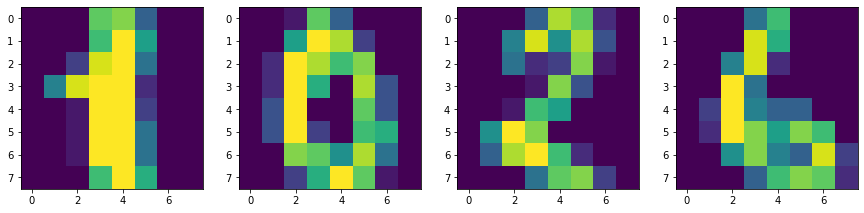

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
# use imshow to plot img 1
plt.imshow(digits['images'][1])

plt.subplot(1, 4, 2)
# use imshow to plot img 101
plt.imshow(digits['images'][101])

plt.subplot(1, 4, 3)
# use imshow to plot img 50
plt.imshow(digits['images'][50])

plt.subplot(1, 4, 4)
# use imshow to plot img 750
plt.imshow(digits['images'][750])

### ========== Question 1.4 ==========

Use `plt.imshow()` to visualize the `mean` and standard deviation (`std`) of the images in the entire dataset. What do you notice about the corner pixels in the image? What does that tell us about the amount of information they give us?

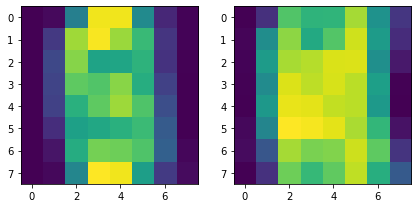

In [8]:
plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
plt.imshow(digits['images'].mean(axis=0))

plt.subplot(1, 2, 2)
plt.imshow(digits['images'].std(axis=0))

### ========== Question 1.5 ==========

Crate a `train`, `test` *and* `validation` split from the data. Use a 60/20/20 split for train/test/validation.

*Hint*: You can use the inbuilt sklearn function `train_test_split` twice, once on the original dataset and once on the resulting set to create the split.

Use `random_seed=42`.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    digits['data'], digits['target'],
    test_size=0.4, random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=1/2, random_state=42
)

## Part 2. Multiclass Linear Model

For our baseline, we will use a [LogisticRegression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), which you used in [Lab 03 - Classification and Evaluation](https://github.com/uoe-iaml/iaml-labs/blob/master/Labs/03%20-%20Classification%20and%20Evaluation.ipynb)


### ========== Question 2.1 ==========
Familiarize yourself with the `multi_class` parameter in the LogisticRegression function to train a one-versus-rest multi-class classifier on the training data.

Use `accuracy_score` to report the accuracy on thetest set. Did you expect the performance to be this good or bad? Why or why not?

Again, use `random_state=42`

In [10]:
# one vs. rest binary classifier
lr_mc = LogisticRegression(multi_class='ovr', random_state=42)
lr_mc.fit(X_train, y_train)

/home/tdinev/miniconda3/envs/py3gen/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
print('LR accuracy: {0:.3f}'.format(accuracy_score(lr_mc.predict(X_test), y_test)))

LR accuracy: 0.958


## Part 3. Classification with Neural Networks

In this part, we will use [Scikit's MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to train a neural network to classify the handwritten digits.

### ========== Question 3.1 ==========

Initialize an MLPClassifier with one hidden layer consisting of 50 neurons, and set early_stopping=True and fit the neural network to the training data. You can leave the other parameters to the default settings. Is the performance better than the linear classifier?

As usual, set `random_state=42`.

In [12]:
# solution
mlp_simple = MLPClassifier(hidden_layer_sizes=(50,), early_stopping=True, random_state=42)
mlp_simple.fit(X_train, y_train)

print('MLP accuracy: {0:.3f}'.format(accuracy_score(mlp_simple.predict(X_test), y_test)))

MLP accuracy: 0.936


### ========== Question 3.2 ==========

In this part, we will perform a grid search over a few of the `MLPClassifier` parameters. Namely, we will look at

- `hidden_layer_sizes`
- `activation`
- `alpha`
- `momentum`

Familiarize yourself with the meaning of the above parameters. If you are curious, here is an in-depth, yet very accessible [article on momentum](https://distill.pub/2017/momentum/).

Then initialize a dictionary that has as keys the above parameters and the following ranges for each

- `hidden_layer_sizes`: 16, 32, 64, 128, 256
- `batch_size`: 64, 128, 256, 512

There are other parameters we could potential vary. Optionally, after you have completed the rest of the lab, you can try to vary the following. Make sure you read the documentation and know what the values mean first!
- `activation`: `relu` and `logistic`
- `alpha`: 1e-3, 1e-4, 1e-5

This dictionary will be used in the provided code for 3.3.

In [13]:
# solution
grid = {
    'hidden_layer_sizes': [16, 32, 64, 128, 256],
#     'activation': ['relu', 'logistic'],
#     'alpha': [1e-3, 1e-4, 1e-5],
    'batch_size': [ 64, 128, 256, 512]
}

### ========== Question 3.3 ==========

In this part, we will use [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) to loop over all possible combinations of settings for the grid search.

Fill in the missing code to instantiate an `MLPClassifier` with the given parameters and fit it on the data.

You can use the `.set_params()` method after you have instantiated the `MLPClassifier`. Set `tol=1e-3`, `solver='adam'`, `random_state=42`, and `max_iter=1000`

In [14]:
# solution
grid_search_results = []

# we provide the for loop
for g in ParameterGrid(grid):
    # Your code goes here
    #   Initialize an MLPClassifier and train it on the *training set*
    mlp = MLPClassifier(max_iter=1000, tol=1e-3, solver='adam', early_stopping=True, random_state=42)
    mlp.set_params(**g)
    mlp.fit(X_train, y_train)
    
    grid_search_results.append({
        'mlp': mlp,
        'params': g,
        # Your code goes here
        #'train_score': # compute the training set accuracy score
        #'val_score': # compute the validation set accuracy score
        
        # solution
        'train_score': accuracy_score(mlp.predict(X_train), y_train),
        'val_score': accuracy_score(mlp.predict(X_val), y_val),
    })

### ========== Question 3.4 ==========

In this part, we will plot the effects of hidden layer sizes on accuracy. We will compute the mean accuracy and a standard deviation for each hidden layer size over other parameter changes. In other words, if `hidden_layer_sizes=50`, we have `4` (or `18`, if you varied `activation` and `alpha`) accuracy scores, one for each of the other parameters.

Read the plotting code below and write code that computes summary statistics from the results of the grid search.

The summary statistics we will look at are the mean and standard deviation of accuracy scores on the training and validation datasets (`train_score` and `val_score` as stored above in `grid_search_results`).

In [15]:
# solution
mean_scores_val, std_scores_val = [], []
mean_scores_train, std_scores_train = [], []

for ls in grid['hidden_layer_sizes']:
    # Let's give them this (up to the next comment)
    mean_scores_val.append(
        np.mean([
            x['val_score'] for x in grid_search_results if x['params']['hidden_layer_sizes'] == ls
        ])
    )
    std_scores_val.append(
        np.std([
            x['val_score'] for x in grid_search_results if x['params']['hidden_layer_sizes'] == ls
        ])
    )
    
    # Your code goes here.
    #  compute the mean and standard deviation on the train set for
    #  all classifiers where hidden_layer_sizes=ls
    mean_scores_train.append(
        np.mean([
            x['train_score'] for x in grid_search_results if x['params']['hidden_layer_sizes'] == ls
        ])
    )
    std_scores_train.append(
        np.std([
            x['train_score'] for x in grid_search_results if x['params']['hidden_layer_sizes'] == ls
        ])
    )
    
# and also give them the below
    
mean_scores_val = np.array(mean_scores_val)
std_scores_val = np.array(std_scores_val)

mean_scores_train = np.array(mean_scores_train)
std_scores_train = np.array(std_scores_train)

In [16]:
# We also give them the below

In [17]:
cm = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size'] = 23

Text(0, 0.5, 'Accuracy score')

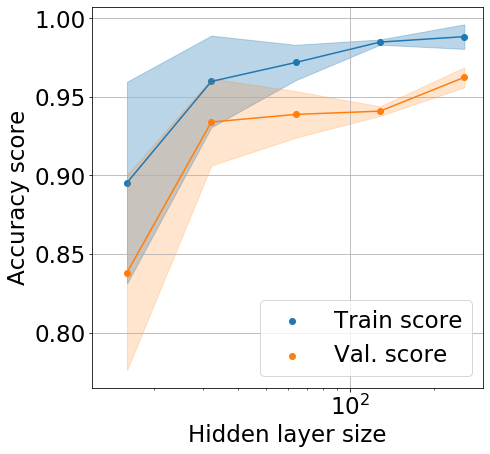

In [18]:
plt.figure(figsize=(7, 7))

plt.plot(grid['hidden_layer_sizes'], mean_scores_train, color=cm[0])
plt.scatter(grid['hidden_layer_sizes'], mean_scores_train, label='Train score',  color=cm[0])
plt.fill_between(
    grid['hidden_layer_sizes'],
    mean_scores_train - std_scores_train, mean_scores_train + std_scores_train,
    alpha=0.3, color=cm[0]
)


plt.plot(grid['hidden_layer_sizes'], mean_scores_val, color=cm[1])
plt.scatter(grid['hidden_layer_sizes'], mean_scores_val, label='Val. score', color=cm[1])
plt.fill_between(
    grid['hidden_layer_sizes'],
    mean_scores_val - std_scores_val, mean_scores_val + std_scores_val,
    alpha=0.2, color=cm[1]
)

plt.xscale('log')
# plt.xlim(10, 266)

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('Hidden layer size')
plt.ylabel('Accuracy score')

### ========== Question 3.4 ==========

Finally, pick the best classifier based on the accuracy score on the validation set.

You can use python's sorted, [which can additionally use a key function](https://docs.python.org/3/howto/sorting.html#key-functions). 

Lastly, report the score of the best classifier on the test set.

In [19]:
grid_search_sorted = sorted(grid_search_results, key=lambda x: x['val_score'], reverse=True)

In [20]:
grid_search_sorted[0]

{'mlp': MLPClassifier(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
               beta_2=0.999, early_stopping=True, epsilon=1e-08,
               hidden_layer_sizes=256, learning_rate='constant',
               learning_rate_init=0.001, max_iter=1000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=42, shuffle=True, solver='adam', tol=0.001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 'params': {'batch_size': 64, 'hidden_layer_sizes': 256},
 'train_score': 0.9935064935064936,
 'val_score': 0.9694444444444444}

In [21]:
mlp_best_grid_search = grid_search_sorted[0]['mlp']
best_acc = accuracy_score(mlp_best_grid_search.predict(X_test), y_test)

print('Fitted MLP acc: {0:.3f}'.format(best_acc))

Fitted MLP acc: 0.969


## Part 4. Feature Importance

In this part, we will randomize a feature and look at its effect on classification. This way we can reason about how important a feature is for classification. If the performance stays the same when the feature is removed (or randomized), then we can reason it has low importance and vice-versa.

### ========== Question 4.1 ==========

Randomize the top-left pixel (index 0) in each image in the test set, then use the `MLPClassifier` with the best settings found above by the grid search. Report the test-set accuracy of the already trained model.

To randomize, generate a uniform random number by calling [np.random.uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html). You need to specify the range -- you can use `np.min` and `np.max` on the original dataset to get the correct values.

Note in this case we are not selecting a model, rather looking at performance, so we are not using a validation set at all.

*Hint*: You can use numpy's [np.copy](https://numpy.org/doc/stable/reference/generated/numpy.copy.html) to copy the train set so you don't overwrite your data.

In [22]:
# set numpy's seed so that we obtain reproducible results
np.random.seed(42)

In [23]:
# solution
X_test_rand = np.copy(X_test)
X_test_rand[:,0] = np.random.uniform(
    low=np.min(digits['images']), high=np.max(digits['images']), size=(X_test.shape[0])
)

In [24]:
opt_params = grid_search_sorted[0]['params']

print('Accuracy with random feature: {0:.3f}'.format(
    accuracy_score(mlp_best_grid_search.predict(X_test_rand), y_test)
))

Accuracy with random feature: 0.969


Did the performance change and by how much? Can you explain the difference?

*Hint:* Go back to the start of the lab where we used `.describe()` on the dataframe you created. Look at the values of the top-left pixel in the original array. What do you see?

### ========== Question 4.2 ==========

Now randomize all the pixels, *one at a time*. For each pixel, record the ratio of the best accuracy score to the one obtained. Use `.imshow()` to plot a 2D grid of the importances for each pixel.

Which pixel is the least/most important? Do you have any intuition why?

In [25]:
# solution
feature_importances = []
for i in range(64):
    X_test_rand = np.copy(X_test)
    X_test_rand[:,i] = np.random.uniform(low=0.0, high=16.0, size=(X_test_rand.shape[0]))
    
    acc_ratio = best_acc / accuracy_score(mlp_best_grid_search.predict(X_test_rand), y_test)
    feature_importances.append(acc_ratio)

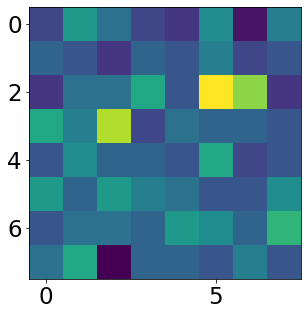

In [26]:
plt.figure(figsize=(5, 5))
plt.imshow(np.array(feature_importances).reshape(8, 8))